---
title: "Modeling and Scoring with Revolution R Enterprise"
author: "Ali Zaidi"
date: "April 1, 2016"
output:
  ioslides_presentation:
    logo: logo-130833979438186239.png
    smaller: yes
    widescreen: yes
  beamer_presentation: default
  slidy_presentation: default
transition: rotate
---


# Introduction

## URL for Today

Please refer to the following url for today's materials:
[http://tinyurl.com/j7okpak](http://tinyurl.com/j7okpak)

## Session Plan | What to Expect

- We will learn in this tutorial how to train and test
models with Revolution R Enterprise.
- Use your knowledge of data manipulation to create **train** and **test** sets.
- Use the modeling functions in RRE to estimate a model.
- Use the `rxPredict` function to test/score a model.
- We will see how you can score models on a variety of data sources.
- Use a functional methodology, i.e., we will create functions to automate the modeling, validation, and scoring process.

## Prerequisites

- Understanding of `rxDataStep` and `xdfs`
- Familiarity with `RevoScaleR` modeling and datastep functions: `rxLinMod`, `rxGlm`, `rxLogit`, `rxDTree`, `rxDForest`, `rxSplit`, and `rxPredict`
- Understand how to write functions in R
- Access to at least one interesting dataset

## Typical Lifecycle

<img src="images/revo-split-life-cycle.png" width="893" height="279px" />

Typical Modeling Lifecycle:

- Start with a data set
- Split into a training set and validation set(s)
- Use the `ScaleR` modeling functions on the train set to estimate your model
- Use `rxPredict` to validate/score your results

## Datasets | Mortgage Dataset

- We will work with mortgage dataset, which contains mortgage and credit profiles for various mortgage holders

In [2]:
username <- "alizaidi"
setwd(paste(getwd(), username, sep = "/"))
getwd()

[1] "C:/Aaqs/IPython Notebooks/alizaidi"

In [3]:
mort_path <- paste(rxGetOption("sampleDataDir"),
                   "mortDefaultSmall.xdf", 
                   sep = "/")
file.copy(mort_path, "mortgage.xdf", overwrite = TRUE)
mort_xdf <- RxXdfData("mortgage.xdf")
rxGetInfo(mort_xdf, getVarInfo = TRUE)

[1] TRUE

File name: C:\Aaqs\IPython Notebooks\alizaidi\mortgage.xdf 
Number of observations: 1e+05 
Number of variables: 6 
Number of blocks: 10 
Compression type: zlib 
Variable information: 
Var 1: creditScore, Type: integer, Low/High: (470, 925)
Var 2: houseAge, Type: integer, Low/High: (0, 40)
Var 3: yearsEmploy, Type: integer, Low/High: (0, 14)
Var 4: ccDebt, Type: integer, Low/High: (0, 14094)
Var 5: year, Type: integer, Low/High: (2000, 2009)
Var 6: default, Type: integer, Low/High: (0, 1)

## Datasets | Convert Default to Categorical

- We might be interested in estimating a classification model for predicting defaults based on credit attributes

In [5]:
rxDataStep(inData = mort_xdf,
           outFile = mort_xdf,
           overwrite = TRUE, 
           transforms = list(default_flag = factor(ifelse(default == 1,
                                                          "default",
                                                          "current"))
                             )
           )

Rows Read: 10000, Total Rows Processed: 10000, Total Chunk Time: 0.016 secondsRows Read: 10000, Total Rows Processed: 20000, Total Chunk Time: 0.015 secondsRows Read: 10000, Total Rows Processed: 30000, Total Chunk Time: 0.016 secondsRows Read: 10000, Total Rows Processed: 40000, Total Chunk Time: 0.141 secondsRows Read: 10000, Total Rows Processed: 50000, Total Chunk Time: 0.015 secondsRows Read: 10000, Total Rows Processed: 60000, Total Chunk Time: 0.016 secondsRows Read: 10000, Total Rows Processed: 70000, Total Chunk Time: 0.015 secondsRows Read: 10000, Total Rows Processed: 80000, Total Chunk Time: 0.016 secondsRows Read: 10000, Total Rows Processed: 90000, Total Chunk Time: 0.016 secondsRows Read: 10000, Total Rows Processed: 100000, Total Chunk Time: 0.015 seconds 


# Modeling
## Generating Training and Test Sets | Create Partition

- The first step to estimating a model is having a clean training dataset.
- We will work with the mortgage data and use `rxSplit` to create partitions.
- `rxSplit` splits an input `.xdf` into multiple `.xdfs`, similar in spirit to the `split` function in base R
- output is a list
- First step is to create a split variable
- We will randomly partition the data into a train and test sample, with 75% in the former, and 25% in the latter

## Generating Training and Test Sets | Partition Function

In [4]:
create_partition <- function(xdf = mort_xdf,
                             partition_size = 0.75,
                             output_path = "/output/", ...) {
  rxDataStep(inData = xdf,
             outFile = xdf,
             transforms = list(
               trainvalidate = factor(
                   ifelse(rbinom(.rxNumRows, 
                                 size = 1, prob = splitperc), 
                          "train", "validate")
               )
           ),
           transformObjects = list(splitperc = partition_size),
           overwrite = TRUE, ...)
  
  splitDS <- rxSplit(inData = xdf, 
                     outFilesBase = "",
                     outFileSuffixes = c("train", "validate"),
                     splitByFactor = "trainvalidate",
                     overwrite = TRUE)
  
  return(splitDS) 
  
}

## Generating Training and Test Sets | List of xdfs

- The `create_partition` function will output a list `xdfs`

In [6]:
mort_split <- create_partition()
names(mort_split) <- c("train", "validate")
lapply(mort_split, rxGetInfo)

Rows Read: 10000, Total Rows Processed: 10000, Total Chunk Time: 0.015 secondsRows Read: 10000, Total Rows Processed: 20000, Total Chunk Time: 0.016 secondsRows Read: 10000, Total Rows Processed: 30000, Total Chunk Time: 0.016 secondsRows Read: 10000, Total Rows Processed: 40000, Total Chunk Time: 0.015 secondsRows Read: 10000, Total Rows Processed: 50000, Total Chunk Time: 0.031 secondsRows Read: 10000, Total Rows Processed: 60000, Total Chunk Time: 0.016 secondsRows Read: 10000, Total Rows Processed: 70000, Total Chunk Time: 0.016 secondsRows Read: 10000, Total Rows Processed: 80000, Total Chunk Time: 0.015 secondsRows Read: 10000, Total Rows Processed: 90000, Total Chunk Time: Less than .001 secondsRows Read: 10000, Total Rows Processed: 100000, Total Chunk Time: 0.032 seconds 
Rows Read: 10000, Total Rows Processed: 10000, Total Chunk Time: 0.047 secondsRows Read: 10000, Total Rows Processed: 20000, Total Chunk Time: 0.047 secondsRows Read: 10000, Total Rows Processed: 30000, Total

ERROR: Error in vapply(seq_along(mapped), function(i) {: values must be length 1,
 but FUN(X[[1]]) result is length 0


$train
File name: C:\Aaqs\IPython Notebooks\alizaidi\mortgage.trainvalidate.train.xdf 
Number of observations: 74807 
Number of variables: 8 
Number of blocks: 10 
Compression type: zlib 

$validate
File name: C:\Aaqs\IPython Notebooks\alizaidi\mortgage.trainvalidate.validate.xdf 
Number of observations: 25193 
Number of variables: 8 
Number of blocks: 10 
Compression type: zlib 


## Build Your Model | Model Formula

- Once you have your training dataset, the most appropriate next step is to estimate your model
- `ScaleR` provides a plethora of modeling functions to choose from: decision trees, ensemble trees, linear models, and generalized linear models.

In [7]:
make_form <- function(xdf = mort_xdf,
                      resp_var = "default_flag",
                      vars_to_skip = c("default", "trainvalidate")) {
  
  library(stringr)
  
  non_incl <- paste(vars_to_skip, collapse = "|")
  
  x_names <- names(xdf)
  
  features <- x_names[!str_detect(x_names, resp_var)]
  features <- features[!str_detect(features, non_incl)]
  
  form <- as.formula(paste(resp_var, paste0(features, collapse = " + "),
                           sep  = " ~ "))
  
  return(form)
}

## Build Your Model | Modeling Function

- Use the `make_form` function inside your favorite `rx` modeling function

In [8]:
make_form()

estimate_model <- function(xdf_data = mort_split[["train"]],
                           form = make_form(xdf_data),
                           model = rxLogit, ...) {
  
  rx_model <- model(form, data = xdf_data)
  
  return(rx_model)
  
  
}

Warning message:
: package 'stringr' was built under R version 3.2.3

default_flag ~ creditScore + houseAge + yearsEmploy + ccDebt + 
    year
<environment: 0x000000001bd6e038>

## Build Your Model | Estimate Your Model

- Let us now train our model using the `estimate_model` function from the last slide

In [9]:
default_model_logit <- estimate_model(mort_split$train, 
                                      reportProgress = 0)

Rows Read: 7438, Total Rows Processed: 7438, Total Chunk Time: Less than .001 seconds
Rows Read: 7482, Total Rows Processed: 14920, Total Chunk Time: 0.016 seconds
Rows Read: 7520, Total Rows Processed: 22440, Total Chunk Time: Less than .001 seconds
Rows Read: 7413, Total Rows Processed: 29853, Total Chunk Time: 0.015 seconds
Rows Read: 7480, Total Rows Processed: 37333, Total Chunk Time: Less than .001 seconds
Rows Read: 7497, Total Rows Processed: 44830, Total Chunk Time: Less than .001 seconds
Rows Read: 7490, Total Rows Processed: 52320, Total Chunk Time: Less than .001 seconds
Rows Read: 7435, Total Rows Processed: 59755, Total Chunk Time: Less than .001 seconds
Rows Read: 7550, Total Rows Processed: 67305, Total Chunk Time: Less than .001 seconds
Rows Read: 7502, Total Rows Processed: 74807, Total Chunk Time: 0.016 seconds 

Starting values (iteration 1) time: 0.047 secs.
Rows Read: 7438, Total Rows Processed: 7438, Total Chunk Time: Less than .001 seconds
Rows Read: 7482, Total

## Building Additional Models | Reusing our Function

- We can change the parameters of the `estimate_model` function to create a different model relatively quickly

In [10]:
default_model_tree <- estimate_model(mort_split$train, 
                                     model = rxDTree, 
                                     cp = 0, type = 'class')


Rows Read: 7438, Total Rows Processed: 7438, Total Chunk Time: Less than .001 seconds
Rows Read: 7482, Total Rows Processed: 14920, Total Chunk Time: 0.015 seconds
Rows Read: 7520, Total Rows Processed: 22440, Total Chunk Time: Less than .001 seconds
Rows Read: 7413, Total Rows Processed: 29853, Total Chunk Time: Less than .001 seconds
Rows Read: 7480, Total Rows Processed: 37333, Total Chunk Time: 0.016 seconds
Rows Read: 7497, Total Rows Processed: 44830, Total Chunk Time: Less than .001 seconds
Rows Read: 7490, Total Rows Processed: 52320, Total Chunk Time: Less than .001 seconds
Rows Read: 7435, Total Rows Processed: 59755, Total Chunk Time: 0.016 seconds
Rows Read: 7550, Total Rows Processed: 67305, Total Chunk Time: Less than .001 seconds
Rows Read: 7502, Total Rows Processed: 74807, Total Chunk Time: Less than .001 seconds 
Rows Read: 7438, Total Rows Processed: 7438, Total Chunk Time: Less than .001 seconds
Rows Read: 7482, Total Rows Processed: 14920, Total Chunk Time: Less th

# Validation
## How Does it Perform on Unseen Data | rxPredict for Logistic Regression



- Now that we have built our model, our next step is to see how it performs on data it has yet to see
- We can use the `rxPredict` function to score/validate our results

In [11]:
default_logit_scored <- rxPredict(default_model_logit,
                                   mort_split$validate,
                                   "scored.xdf",
                                  writeModelVars = TRUE)

Rows Read: 2562, Total Rows Processed: 2562, Total Chunk Time: 0.015 seconds
Rows Read: 2518, Total Rows Processed: 5080, Total Chunk Time: Less than .001 seconds
Rows Read: 2480, Total Rows Processed: 7560, Total Chunk Time: Less than .001 seconds
Rows Read: 2587, Total Rows Processed: 10147, Total Chunk Time: Less than .001 seconds
Rows Read: 2520, Total Rows Processed: 12667, Total Chunk Time: 0.016 seconds
Rows Read: 2503, Total Rows Processed: 15170, Total Chunk Time: Less than .001 seconds
Rows Read: 2510, Total Rows Processed: 17680, Total Chunk Time: Less than .001 seconds
Rows Read: 2565, Total Rows Processed: 20245, Total Chunk Time: Less than .001 seconds
Rows Read: 2450, Total Rows Processed: 22695, Total Chunk Time: 0.016 seconds
Rows Read: 2498, Total Rows Processed: 25193, Total Chunk Time: Less than .001 seconds 


## Get Receiver Operator Characteristics

- We can visualize our test results

In [12]:
rxGetInfo(default_logit_scored, numRows = 2)
rxDataStep(inData = default_logit_scored, 
           outFile = default_logit_scored,
           transforms = list(default_binary = ifelse(default_flag == "default",
                                                     1, 
                                                     0)),
           overwrite = TRUE)

File name: C:\Aaqs\IPython Notebooks\alizaidi\scored.xdf 
Number of observations: 25193 
Number of variables: 7 
Number of blocks: 10 
Compression type: zlib 
Data (2 rows starting with row 1):
  default_flag_Pred default_flag creditScore houseAge yearsEmploy ccDebt year
1      5.343999e-06      current         691        4           4   5077 2000
2      5.857723e-07      current         743       18           3   3080 2000

Rows Read: 2562, Total Rows Processed: 2562, Total Chunk Time: 0.015 secondsRows Read: 2518, Total Rows Processed: 5080, Total Chunk Time: Less than .001 secondsRows Read: 2480, Total Rows Processed: 7560, Total Chunk Time: Less than .001 secondsRows Read: 2587, Total Rows Processed: 10147, Total Chunk Time: 0.016 secondsRows Read: 2520, Total Rows Processed: 12667, Total Chunk Time: Less than .001 secondsRows Read: 2503, Total Rows Processed: 15170, Total Chunk Time: Less than .001 secondsRows Read: 2510, Total Rows Processed: 17680, Total Chunk Time: 0.015 secondsRows Read: 2565, Total Rows Processed: 20245, Total Chunk Time: Less than .001 secondsRows Read: 2450, Total Rows Processed: 22695, Total Chunk Time: Less than .001 secondsRows Read: 2498, Total Rows Processed: 25193, Total Chunk Time: 0.016 seconds 


## Visualize Model Results

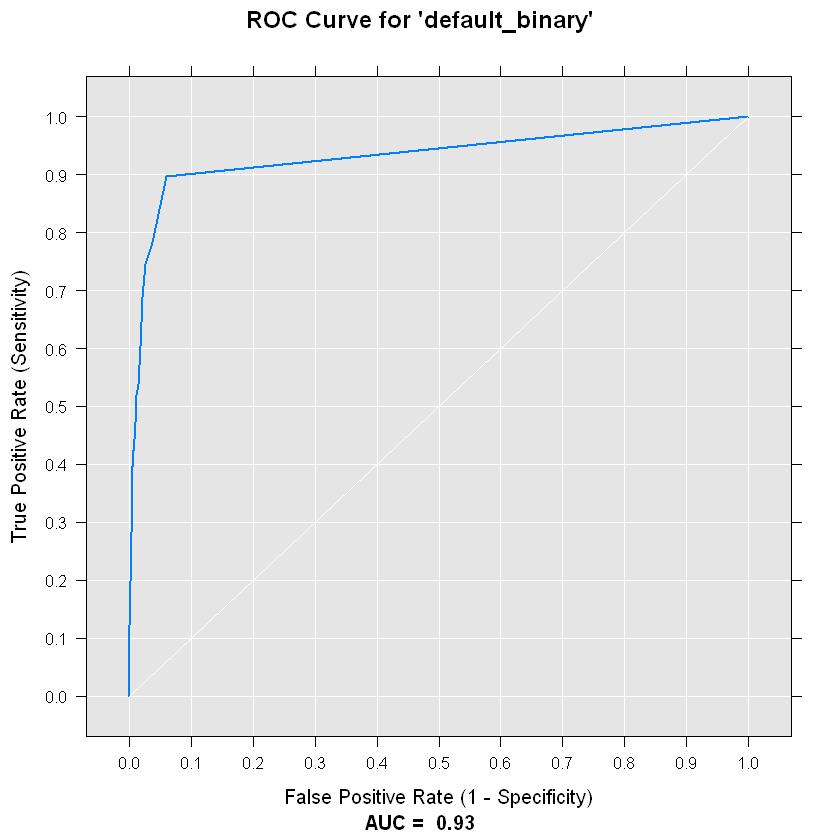

In [13]:
rxRocCurve("default_binary", "default_flag_Pred", data = default_logit_scored)

## Testing a Second Model | rxPredict for Decision Tree

- We saw how easy it was to train on different in the previous sections
- Similary simple to test different models

In [14]:
default_tree_scored <- rxPredict(default_model_tree,
                                  mort_split$validate,
                                  "scored.xdf",
                                  writeModelVars = TRUE)

Rows Read: 2562, Total Rows Processed: 2562, Total Chunk Time: Less than .001 seconds
Rows Read: 2518, Total Rows Processed: 5080, Total Chunk Time: Less than .001 seconds
Rows Read: 2480, Total Rows Processed: 7560, Total Chunk Time: 0.015 seconds
Rows Read: 2587, Total Rows Processed: 10147, Total Chunk Time: Less than .001 seconds
Rows Read: 2520, Total Rows Processed: 12667, Total Chunk Time: Less than .001 seconds
Rows Read: 2503, Total Rows Processed: 15170, Total Chunk Time: Less than .001 seconds
Rows Read: 2510, Total Rows Processed: 17680, Total Chunk Time: Less than .001 seconds
Rows Read: 2565, Total Rows Processed: 20245, Total Chunk Time: Less than .001 seconds
Rows Read: 2450, Total Rows Processed: 22695, Total Chunk Time: 0.016 seconds
Rows Read: 2498, Total Rows Processed: 25193, Total Chunk Time: Less than .001 seconds 


## Visualize Multiple ROCs

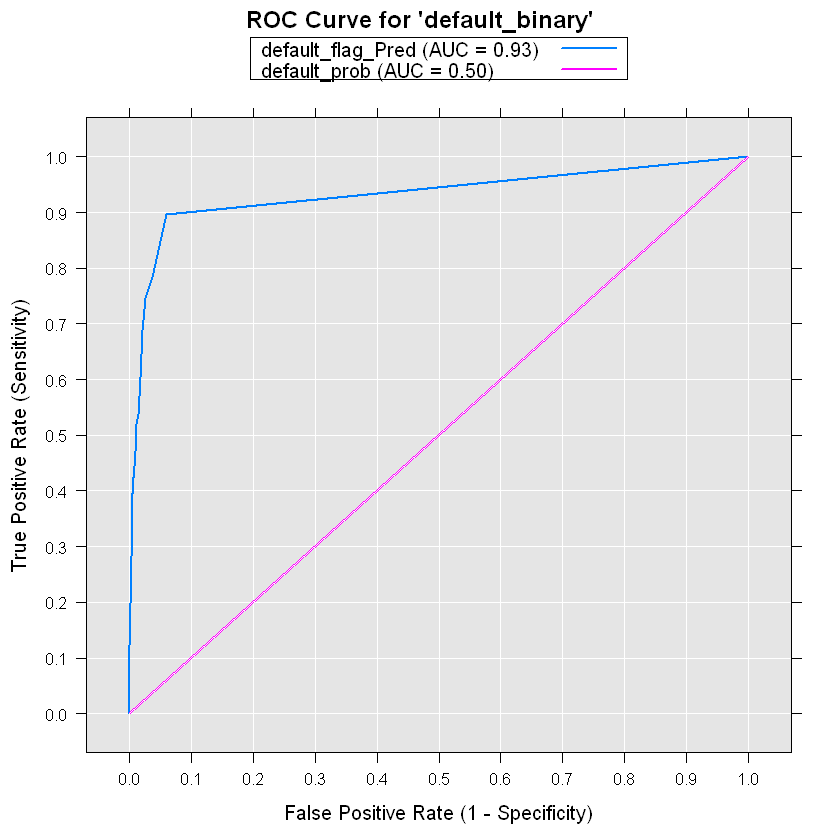

In [15]:
rxRocCurve("default_binary", 
           c("default_flag_Pred", "default_prob"), 
           data = default_tree_scored)

# Additional Topics

## Scoring on Non-XDF Data Sources | Using CSV

- The previous slides focused on using xdf data sources
- Most of the `rx` functions will work on non-xdf data sources
- For training, which is often an iterative process, it is recommended to use xdfs
- For scoring/testing, which requires just one pass through the data, feel free to use raw data!

In [16]:
csv_path <- paste(rxGetOption("sampleDataDir"),
                   "mortDefaultSmall2009.csv", 
                   sep = "/")
file.copy(csv_path, "mortDefaultSmall2009.csv", overwrite = TRUE)

mort_csv <- RxTextData("mortDefaultSmall2009.csv")

[1] TRUE

## Regression Tree

- For a slightly different model, we will estimate a regression tree.
- Just change the parameters in the `estimate_model` function

In [17]:
tree_model_ccdebt <- estimate_model(xdf_data = mort_split$train, 
                                    form = make_form(mort_split$train, 
                                                     "ccDebt", 
                                                     vars_to_skip = c("default_flag",
                                                                      "trainvalidate")), 
                                    model = rxDTree)
# plot(RevoTreeView::createTreeView(tree_model_ccdebt))

Rows Read: 7438, Total Rows Processed: 7438, Total Chunk Time: Less than .001 seconds
Rows Read: 7482, Total Rows Processed: 14920, Total Chunk Time: Less than .001 seconds
Rows Read: 7520, Total Rows Processed: 22440, Total Chunk Time: 0.015 seconds
Rows Read: 7413, Total Rows Processed: 29853, Total Chunk Time: Less than .001 seconds
Rows Read: 7480, Total Rows Processed: 37333, Total Chunk Time: Less than .001 seconds
Rows Read: 7497, Total Rows Processed: 44830, Total Chunk Time: 0.016 seconds
Rows Read: 7490, Total Rows Processed: 52320, Total Chunk Time: Less than .001 seconds
Rows Read: 7435, Total Rows Processed: 59755, Total Chunk Time: Less than .001 seconds
Rows Read: 7550, Total Rows Processed: 67305, Total Chunk Time: 0.016 seconds
Rows Read: 7502, Total Rows Processed: 74807, Total Chunk Time: Less than .001 seconds 
Rows Read: 7438, Total Rows Processed: 7438, Total Chunk Time: Less than .001 seconds
Rows Read: 7482, Total Rows Processed: 14920, Total Chunk Time: 0.016 s

## Test on CSV

In [18]:
rxPredict(tree_model_ccdebt, 
          data = mort_csv, 
          outData = "mort2009predictions.xdf", 
          writeModelVars = TRUE)

mort_2009_pred <- RxXdfData("mort2009predictions.xdf")
rxGetInfo(mort_2009_pred, numRows = 1)

Rows Read: 10000, Total Rows Processed: 10000, Total Chunk Time: 0.015 seconds 


File name: C:\Aaqs\IPython Notebooks\alizaidi\mort2009predictions.xdf 
Number of observations: 10000 
Number of variables: 7 
Number of blocks: 1 
Compression type: zlib 
Data (1 row starting with row 1):
  ccDebt_Pred ccDebt creditScore houseAge yearsEmploy year default
1    4932.883   3661         701       23           2 2009       0

# Multiclass Classification
## Convert Year to Factor

- We have seen how to estimate a binary classification model and a regression tree
- How would we estimate a multiclass classification model?
- Let's try to predict mortgage origination based on other variables
- Use `rxFactors` to convert *year* to a _factor_ variable

In [19]:
mort_xdf_factor <- rxFactors(inData = mort_xdf, 
                             factorInfo = c("year"), 
                             outFile = "mort_year.xdf", 
                             overwrite = TRUE)

Rows Read: 10000, Total Rows Processed: 10000, Total Chunk Time: 0.016 seconds
Rows Read: 10000, Total Rows Processed: 20000, Total Chunk Time: 0.015 seconds
Rows Read: 10000, Total Rows Processed: 30000, Total Chunk Time: Less than .001 seconds
Rows Read: 10000, Total Rows Processed: 40000, Total Chunk Time: 0.016 seconds
Rows Read: 10000, Total Rows Processed: 50000, Total Chunk Time: 0.015 seconds
Rows Read: 10000, Total Rows Processed: 60000, Total Chunk Time: 0.016 seconds
Rows Read: 10000, Total Rows Processed: 70000, Total Chunk Time: 0.016 seconds
Rows Read: 10000, Total Rows Processed: 80000, Total Chunk Time: 0.015 seconds
Rows Read: 10000, Total Rows Processed: 90000, Total Chunk Time: 0.016 seconds
Rows Read: 10000, Total Rows Processed: 100000, Total Chunk Time: 0.016 seconds 


## Convert Year to Factor

In [20]:
rxGetInfo(mort_xdf_factor, getVarInfo = TRUE)

File name: C:\Aaqs\IPython Notebooks\alizaidi\mort_year.xdf 
Number of observations: 1e+05 
Number of variables: 8 
Number of blocks: 10 
Compression type: zlib 
Variable information: 
Var 1: creditScore, Type: integer, Low/High: (470, 925)
Var 2: houseAge, Type: integer, Low/High: (0, 40)
Var 3: yearsEmploy, Type: integer, Low/High: (0, 14)
Var 4: ccDebt, Type: integer, Low/High: (0, 14094)
Var 5: year
       10 factor levels: 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009
Var 6: default, Type: integer, Low/High: (0, 1)
Var 7: default_flag
       2 factor levels: current default
Var 8: trainvalidate
       2 factor levels: train validate

## Estimate Multiclass Classification

- You know the drill! Change the parameters in `estimate_model`:

In [21]:
tree_multiclass_year <- estimate_model(xdf_data = mort_xdf_factor, 
                                    form = make_form(mort_xdf_factor, 
                                                     "year", 
                                                     vars_to_skip = c("default", 
                                                                      "trainvalidate")), 
                                    model = rxDTree, type = "class")

Rows Read: 10000, Total Rows Processed: 10000, Total Chunk Time: Less than .001 seconds
Rows Read: 10000, Total Rows Processed: 20000, Total Chunk Time: Less than .001 seconds
Rows Read: 10000, Total Rows Processed: 30000, Total Chunk Time: Less than .001 seconds
Rows Read: 10000, Total Rows Processed: 40000, Total Chunk Time: 0.016 seconds
Rows Read: 10000, Total Rows Processed: 50000, Total Chunk Time: Less than .001 seconds
Rows Read: 10000, Total Rows Processed: 60000, Total Chunk Time: Less than .001 seconds
Rows Read: 10000, Total Rows Processed: 70000, Total Chunk Time: Less than .001 seconds
Rows Read: 10000, Total Rows Processed: 80000, Total Chunk Time: 0.016 seconds
Rows Read: 10000, Total Rows Processed: 90000, Total Chunk Time: Less than .001 seconds
Rows Read: 10000, Total Rows Processed: 100000, Total Chunk Time: Less than .001 seconds 
Rows Read: 10000, Total Rows Processed: 10000, Total Chunk Time: Less than .001 seconds
Rows Read: 10000, Total Rows Processed: 20000, T

## Predict Multiclass Classification

- Score the results

In [22]:
multiclass_preds <- rxPredict(tree_multiclass_year, 
                              data = mort_xdf_factor, 
                              writeModelVars = TRUE, 
                              outData = "multi.xdf",
                              overwrite = TRUE)

Rows Read: 10000, Total Rows Processed: 10000, Total Chunk Time: Less than .001 seconds
Rows Read: 10000, Total Rows Processed: 20000, Total Chunk Time: 0.015 seconds
Rows Read: 10000, Total Rows Processed: 30000, Total Chunk Time: 0.031 seconds
Rows Read: 10000, Total Rows Processed: 40000, Total Chunk Time: 0.032 seconds
Rows Read: 10000, Total Rows Processed: 50000, Total Chunk Time: 0.031 seconds
Rows Read: 10000, Total Rows Processed: 60000, Total Chunk Time: 0.031 seconds
Rows Read: 10000, Total Rows Processed: 70000, Total Chunk Time: 0.031 seconds
Rows Read: 10000, Total Rows Processed: 80000, Total Chunk Time: 0.032 seconds
Rows Read: 10000, Total Rows Processed: 90000, Total Chunk Time: 0.015 seconds
Rows Read: 10000, Total Rows Processed: 100000, Total Chunk Time: 0.032 seconds 


## Predict Multiclass Classification

- View the results
- Predicted/scored column for each level of the response
- Sum up to one

In [23]:
rxGetInfo(multiclass_preds, numRows = 1)

File name: C:\Aaqs\IPython Notebooks\alizaidi\multi.xdf 
Number of observations: 1e+05 
Number of variables: 14 
Number of blocks: 10 
Compression type: zlib 
Data (1 row starting with row 1):
   2000_prob  2001_prob  2002_prob  2003_prob 2004_prob 2005_prob 2006_prob
1 0.09419223 0.09792822 0.09373939 0.09611683 0.1000792 0.1023435 0.1030228
  2007_prob 2008_prob 2009_prob year creditScore houseAge ccDebt
1 0.1067587 0.1024567 0.1033624 2000         691       16   6725

# Conclusion

## Thanks for Attending!

- Any questions?
- Try different models!
- Try modeling with `rxDForest`, `rxBTrees`: have significantly higher predictive accuracy, somewhat less interpretability
- [alizaidi@microsoft.com](mailto:alizaidi@microsoft.com)